In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time
import superpixels as sp

In [4]:
ground_path = 'BSDS500/data/groundTruth/train/'
train_path = 'BSDS500/data/images/train/'
save_path = 'save/'
bound_prefix = save_path + 'bound_'
eval_prefix = save_path + 'precision_'
extension = '.npz'

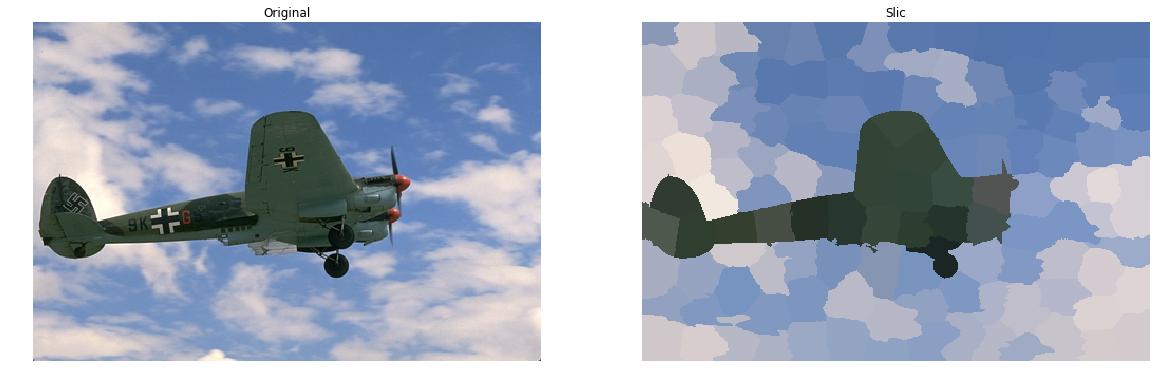

In [5]:
imagePath = 'images/'
imageFile ='3063.jpg'
image = img_as_float(io.imread((imagePath + imageFile)))

seg_slic = slic(image, n_segments = 128, slic_zero = True)

s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)

fig, (ax2, ax3) = plt.subplots(1,2, figsize=(20, 20))
ax2.imshow(image)
ax2.set_title("Original")
ax2.set_axis_off()
ax3.imshow(s_image)
ax3.set_title("Slic")
ax3.set_axis_off()
plt.show() 

In [103]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

cutz_images, cutz_nsegs = sp.generate_ultrametric_map(img, colors, seg_slic, n_segs
                                                      , step =2, start_at = 40, stop_at = 10)
print(len(cutz_images))


16


In [104]:
ground_file ='3063.mat'
groundtruth = pgt.get_groundTruth(imagePath + ground_file)

ground_image = np.zeros(image.shape,dtype=np.uint8)
for i in range(0,3):
    ground_image[:, :, i] = groundtruth[:, :, 0]

img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)
    
best_fmeasure = 0
for i in range(len(cutz_images)):
    precision, recall = ev.eval_bound(groundtruth, cutz_images[i][:,:,0:1], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
        
    print(fmeasure, i)
    
print(best_fmeasure)

0.153487947407 0
0.168301655426 1
0.168301655426 2
0.168428615416 3
0.167544675137 4
0.17350766263 5
0.17350766263 6
0.184288796874 7
0.188890899222 8
0.191181873852 9
0.197968253968 10
0.20123738196 11
0.202108847993 12
0.220356308411 13
0.223711961434 14
0.226951444376 15
0.226951444376


### Read Groundtruth

In [6]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

images = []
groundtruths = []

#load images
for filename in ground_filenames:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)
    
print(len(groundtruths), len(images))

200 200


### Generate boundaries and save results

In [114]:
ini = 20 #0
fim = 40 #len(ground_filenames)

methods = ['hslic']

index = 0

for method in methods:
    boundname = bound_prefix + method + extension

    borders = []
    last_shape = None
    img = None
    
    starttime = time.time()
    for groundtruth, image in zip(groundtruths[ini:fim], images[ini:fim]):
        if(image.shape != last_shape):
            img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
            img.fill(255)
            last_shape = image.shape
        
        seg_slic = slic(image, n_segments = 128, slic_zero = True)
        s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)
        cutz_images, cutz_nsegs = sp.generate_ultrametric_map(img, colors, seg_slic, n_segs
                                                              , step =2, start_at = 40, stop_at = 10)
        
        borders.append(cutz_images)
        
        index += 1
        if index % 5 == 0:
            print(index)

    endtime = time.time()
        
    np.savez(boundname, borders=borders)
    print(boundname)
    print((endtime - starttime), 'seconds')

20
save/bound_hslic.npz
111.69087624549866 seconds


### Recover boundaries and evaluate results

In [9]:
ini = 20 #0
fim = 40 #len(ground_filenames)

methods = ['hslic']

for method in methods:
    boundname = bound_prefix + method + extension
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(boundname)
    boundaries = npload['borders']

    #start precision method
    precisions, recalls = [], []
    cutz_precs, cutz_recs = [], []
    threshold = 0

    starttime = time.time()
    
    for groundtruth, cutz_images in zip(groundtruths[ini:fim], boundaries):
        for cutz_image in cutz_images:
            precision, recall = ev.eval_bound(groundtruth, cutz_image[:,:,0:1], threshold, True)
            
            cutz_precs.append(precision)
            cutz_recs.append(recall)
            
        precisions.append(cutz_precs)
        recalls.append(cutz_recs)

    endtime = time.time()
    
    #save precision file
    np.savez(evalname, precisions=precisions, recalls=recalls)
    print(evalname)
    print((endtime - starttime), 'seconds')

save/precision_hslic.npz
111.42344284057617 seconds


### Load evaluations and calculate f-measures

In [34]:
methods = ['sgb', 'egb', 'slic']
fmeasures = []

for method in methods:
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(evalname)
    precisions = npload['precisions']
    recalls = npload['recalls']

    np_precisions = (np.array(precisions))
    np_recalls = (np.array(recalls))

    fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
    
    fmeasures.append(fmeasure)

### Plot curve

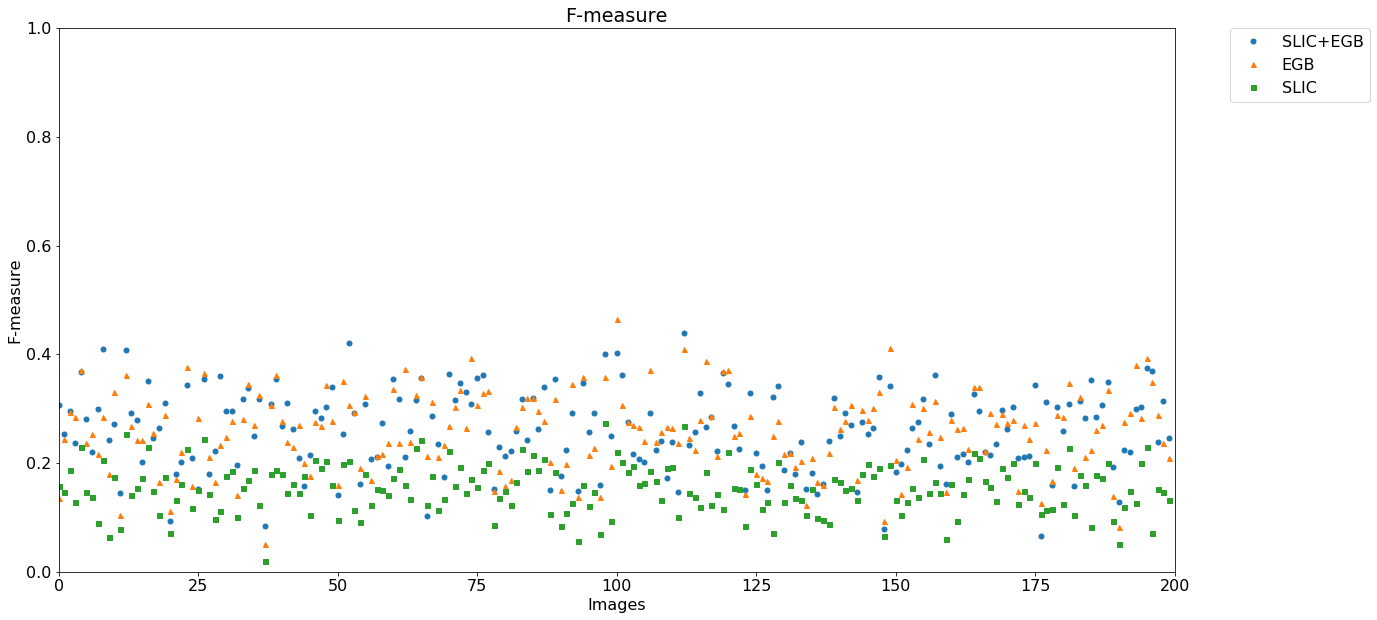

In [36]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

plt.plot(fmeasures[0], label='SLIC+EGB', marker='o', markersize=5, linewidth=0)
plt.plot(fmeasures[1], label='EGB', marker='^', markersize=5, linewidth=0)
plt.plot(fmeasures[2], label='SLIC', marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, itens, 0, 1])

plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()

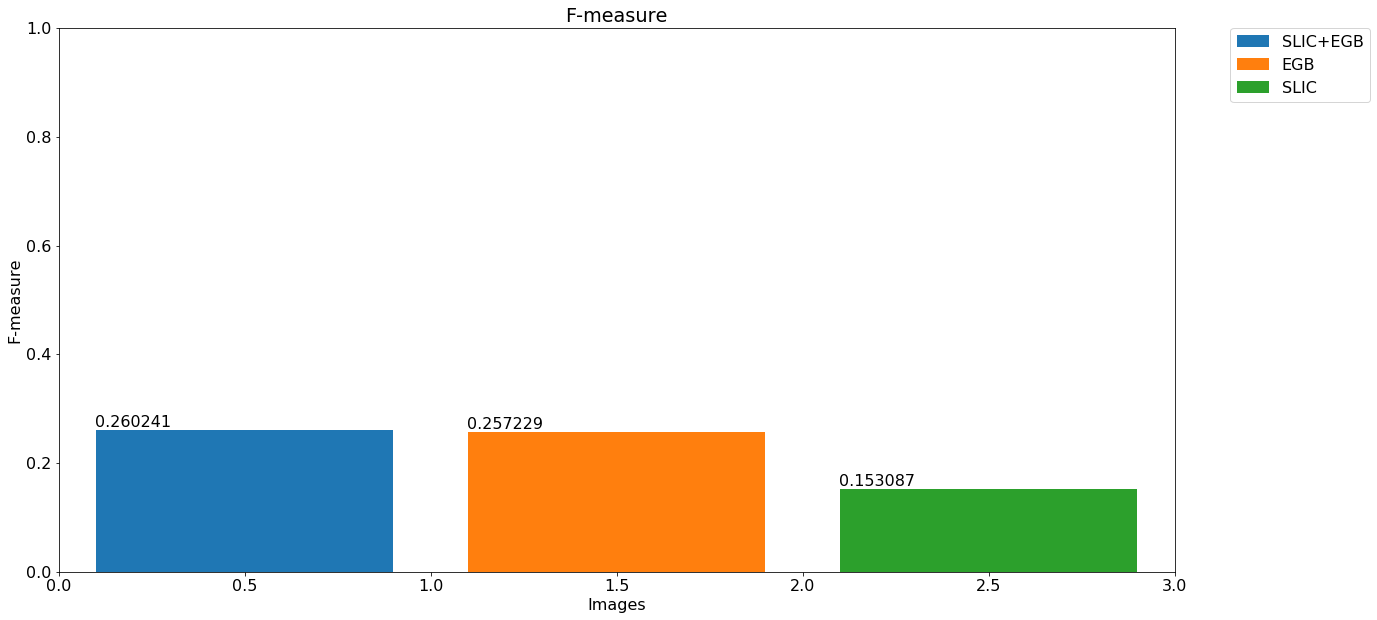

In [35]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, np.average(fmeasures[0]), label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, np.average(fmeasures[1]), label='EGB') #, marker='^', markersize=5, linewidth=0)
bar3 = plt.bar(2.5, np.average(fmeasures[2]), label='SLIC') #, marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, 3, 0, 1])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(rect.get_x()+0.1, height, '%2f' % height, ha='center', va='bottom')


plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()

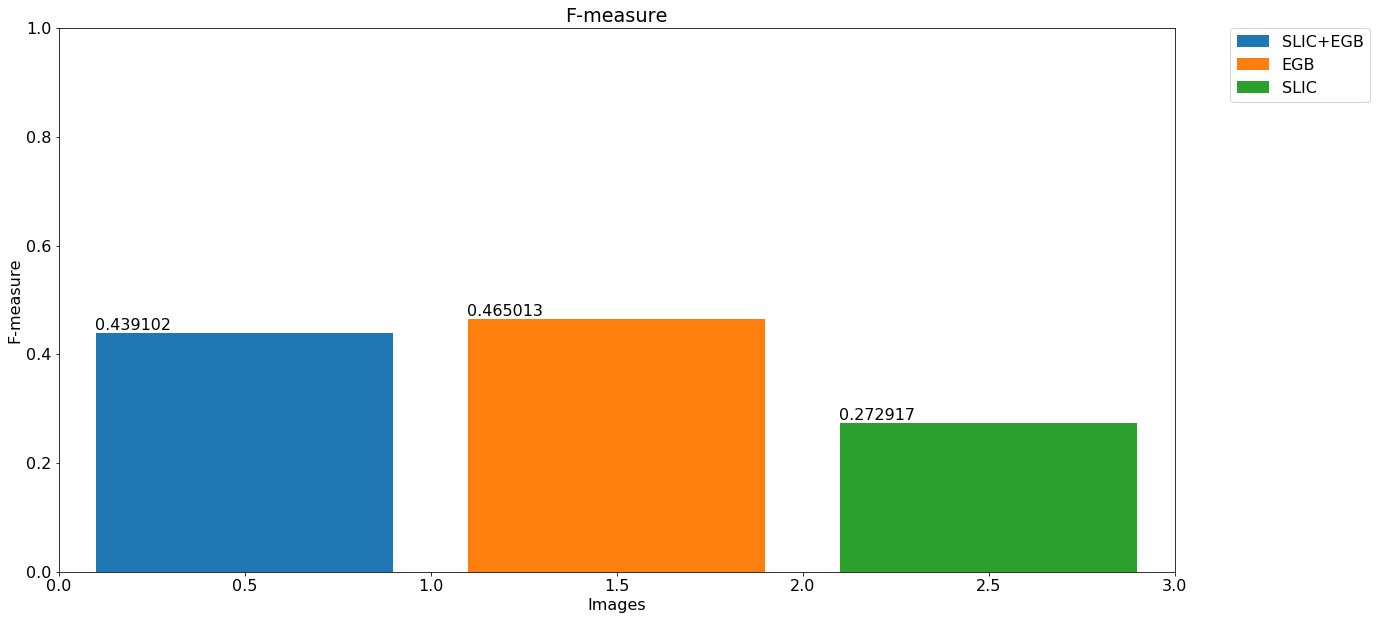

In [37]:
itens = len(fmeasures[0])

#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, np.max(fmeasures[0]), label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, np.max(fmeasures[1]), label='EGB') #, marker='^', markersize=5, linewidth=0)
bar3 = plt.bar(2.5, np.max(fmeasures[2]), label='SLIC') #, marker='s', markersize=5, linewidth=0)

plt.rcParams["font.size"] = 16
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis([0, 3, 0, 1])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(rect.get_x()+0.1, height, '%2f' % height, ha='center', va='bottom')

plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()

In [ ]:
best_fmeasure = 0
best_slic = 0
best_felz = 0
threshold = 0

precisions, recalls = [], []

for slic_index in range(1408, 512, -128):
    for felz_index in range(1024, 2048, 128):
        for groundtruth, image in zip(groundtruths[20:40], images[20:40]):
            _, border, _ = sp.process_image(image
                                        , slic_segments = slic_index
                                        , felz_scale = felz_index
                                        , felz_min_size = 30
                                        , ultrametric = False
                                        , save=False)
            
        
            precision, recall = ev.eval_bound(groundtruth, border[:, :, 0:1], threshold, True)    
            precisions.append(precision)
            recalls.append(recall)
        
        np_precisions = (np.array(precisions))
        np_recalls = (np.array(recalls))

        fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
        fmeasure = np.average(fmeasure)
        
        if fmeasure > best_fmeasure:
            best_fmeasure = fmeasure
            best_slic = slic_index
            best_felz = felz_index

        print(fmeasure, slic_index, felz_index, best_slic, best_felz)
        
        precision = []
        recall = []
                    
print('Max f-measure: ', best_fmeasure)
print('Best slic: ', best_slic)
print('Best felz:', best_felz)    